In [1]:
## Import necessary stuff. 

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Special imports
import utils
import logomaker

# JAX imports
import jax.numpy as jnp
import jax.random as random

# Numpyro imports
import numpyro
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
import numpyro.distributions as dist

%matplotlib inline

fig_name = 'fig6'

In [2]:
# Set figure style
style_file_name = f'fig.style'
s = """
axes.linewidth:     1.0  # width of spines 
font.size:          7.0  # default font size
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0  # fontsize of title
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
axes.labelpad:      1.0     # space between label and axis
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
# generate random keys for training and predictions
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

In [4]:
def load_data(sheet_name=None):
    # Name of excel file
    file_name = '../data/qPCR/dose_response_curves.xlsx'
    
    # Return sheet names if none specified
    if sheet_name is None:
        return pd.ExcelFile(file_name).sheet_names
    
    # Load data from Excel sheet
    data_df = pd.read_excel(file_name,
                            sheet_name=sheet_name, header=[0, 1], index_col=[0, 1])
    data_df.index.rename(['conc', 'bio_rep'], inplace=True)
    data_df.columns.rename(['primers', 'tech_rep'], inplace=True)

    # Pivot to make tidy data
    tidy_df = data_df.melt(value_name='cycles',
                           ignore_index=False).reset_index()
    
    # For each (conc, bio_rep) compute mean of cycles across tech_rep
    df = tidy_df.groupby(['conc','bio_rep','primers']).mean()['cycles'].to_frame().reset_index()
    df = df.pivot(index=['conc','bio_rep'],columns='primers', values='cycles')

    # Compute dCt values (NOTE: exclusion - inclusion !)
    df['dCt'] = df['exclusion'] - df['inclusion']
    df = df.reset_index()[['conc','bio_rep','dCt']]
    df.columns.name = ''
    
    return df

In [5]:
def load_mcmc_samples(sheet_name):
    mcmc_file_name = f'../mcmc_samples/mcmc_{sheet_name}.pkl'
    with open(mcmc_file_name, 'rb') as f:
        mcmc_samples = pickle.load(f)
    return mcmc_samples

In [6]:
### MUST BE SAME AS IN INFERENCE SCRIPT
def single_drug_model(x, y=None):

    # Context strength
    log10_S = numpyro.sample("log10_S", dist.Uniform(low=-3, high=3))
    S=numpyro.deterministic('S', 10.0**log10_S)

    # Hill coefficient
    log2_H = numpyro.sample("log2_H", dist.Normal(loc=0, scale=2))
    H=numpyro.deterministic('H', 2.0**log2_H)

    # Normalizing concentration
    log10_NC = numpyro.sample("log10_NC", dist.Uniform(low=-3, high=3))
    NC=numpyro.deterministic('NC',10.0**log10_NC)

    # Measurement noise
    log10_sigma = numpyro.sample("log10_sigma", dist.Uniform(low=-2, high=2))
    sigma = numpyro.deterministic('sigma',10.0**log10_sigma)

    # Amplitude
    log10_alpha = numpyro.sample("log10_alpha", dist.Uniform(low=0, high=6))
    alpha = numpyro.deterministic('alpha',10.0**log10_alpha)
    
    # R = inclusion / exclusion
    R = numpyro.deterministic('R', S*(1 + (x/NC)**H)/(1 + (1/alpha)*(x/NC)**H))
    log2_R = numpyro.deterministic('log2_R', jnp.log2(R))
    numpyro.sample('yhat', dist.Normal(log2_R, sigma), obs=y)

In [7]:
# def synergy_drug_model(x1=None, x2=None, y=None):   
#     # Priors
    
#     # Context strength
#     log10_S = numpyro.sample("log10_S", dist.Uniform(low=-3, high=3))
    
#     ## log2 Hill coefficients
#     log2_H1 = numpyro.sample('log2_H1', dist.Normal(loc=0, scale = 2))
#     log2_H2 = numpyro.sample('log2_H2', dist.Normal(loc=0, scale = 2))
    
#     ## log2 maximal effects
#     log10_M1 = numpyro.sample('log10_M1', dist.Uniform(low=1, high=6))
#     log10_M2 = numpyro.sample('log10_M2', dist.Uniform(low=1, high=6))
    
#     # Normalizing concentration
#     log10_NC1 = numpyro.sample("log10_NC1", dist.Uniform(low=-3, high=3))
#     log10_NC2 = numpyro.sample("log10_NC2", dist.Uniform(low=-3, high=3))

#     ## Noise magnitude, assumed the same for all experiments
#     log10_sigma = numpyro.sample("log10_sigma", dist.Uniform(low=-2, high=2))
    
#     ## Tracking the variable in original scale
#     #S   = numpyro.deterministic('S', 10.**log10_S)
#     #S   = numpyro.deterministic('S', 10.**-.5)
#     H1  = numpyro.deterministic('H1', jnp.exp2(log2_H1))
#     H2  = numpyro.deterministic('H2', jnp.exp2(log2_H2))
#     M1  = numpyro.deterministic('M1', 10.**log10_M1)
#     M2  = numpyro.deterministic('M2', 10.**log10_M2)
#     NC1 = numpyro.deterministic('NC1', 10.0**log10_NC1)
#     NC2 = numpyro.deterministic('NC2', 10.0**log10_NC2)
#     sigma = numpyro.deterministic('sigma',10.0**log10_sigma)
    
#     # Drug effects with saturation
#     E1 = numpyro.deterministic('E1', (1+(x1/NC1)**H1)/(1+(1/M1)*(x1/NC1)**H1))
#     E2 = numpyro.deterministic('E2', (1+(x2/NC2)**H2)/(1+(1/M2)*(x2/NC2)**H2))
    
#     # Compute log2 ratio 
#     R = numpyro.deterministic('R', S*E1*E2)
#     dCt = numpyro.deterministic('log2_R', jnp.log2(R))
    
#     # Compute PSI
#     psi = numpyro.deterministic('psi', R/(1+R) )
    
#     # Pin log2 ratios to C_t values. Note: all 3 experiments get the same sigma. 
#     numpyro.sample('cthat', dist.Normal(dCt, sigma), obs=y)

In [8]:
EC2x = {'risdiplam': 14,
        'branaplam': 7,
        'ASOi6': 0.6,
        'ASOi7': 0.1,
        'RECTAS': 0.2,
        'ASOi20': 0.08}

In [9]:
def plot_data(ax, x, y, x_left):
    ix = x>0
    ax.scatter(x[ix], 
               y[ix], 
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)
    n_zero = sum(~ix)
    x_zero = x_left*np.ones(n_zero)
    y_zero = y[~ix]
    ax.scatter(x_zero,
               y_zero,
               marker='<',
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)

In [10]:
def log_ticks_from_lims(lim):   
    # Compute xticks and yticks
    log_tick_lo = np.ceil(np.log10(lim[0])).astype(int)
    log_tick_hi = np.floor(np.log10(lim[1])).astype(int)
    ticks = [10**tick for tick in range(log_tick_lo, log_tick_hi+1)]
    return ticks
    
log_ticks_from_lims([1E-3, 1E3])

[0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [11]:
def load_mix_samples(drug1_sheet, drug2_sheet, subsample_size=100):

    # Load MCMC samples for each drug
    drug1_mcmc_samples = load_mcmc_samples(drug1_sheet)
    drug2_mcmc_samples = load_mcmc_samples(drug2_sheet)

    # Create mix_mcmc_samples
    mix_mcmc_samples = {}
    num_samples = len(drug1_mcmc_samples['log10_NC'])
    mix_mcmc_samples['log10_NC1'] = drug1_mcmc_samples['log10_NC']
    mix_mcmc_samples['log10_M1'] = drug1_mcmc_samples['log10_alpha']
    mix_mcmc_samples['log2_H1'] = drug1_mcmc_samples['log2_H']
    mix_mcmc_samples['log10_NC2'] = drug2_mcmc_samples['log10_NC']
    mix_mcmc_samples['log10_M2'] = drug2_mcmc_samples['log10_alpha']
    mix_mcmc_samples['log2_H2'] = drug2_mcmc_samples['log2_H']
    
    ix = np.random.choice(a=num_samples, size=subsample_size, replace=False)
    for key in mix_mcmc_samples.keys():
        mix_mcmc_samples[key] = mix_mcmc_samples[key][ix]
    
    return mix_mcmc_samples

In [12]:
def plot_single_drug(ax,
                     minigene,
                     drug,
                     sheet_name,
                     color,
                     xlim,
                     ylim,
                     show_ylabel=True,
                     show_yticklabels=True,
                     show_H=True,
                     units='nM',
                     text_fontsize=7,
                     two_lines=False):
    """Plots data for a single drug on top of model preditions for that drug."""

    # Get ticks
    xticks = log_ticks_from_lims(xlim)
    yticks = log_ticks_from_lims(ylim)

    # Load data
    data_df = load_data(sheet_name)
    x = data_df['conc'].values
    y = 2.**data_df['dCt'].values

    # Load MCMC samples
    mcmc_samples = load_mcmc_samples(sheet_name)

    # Define concentration grid
    x_grid = np.logspace(np.log10(xlim[0]),
                         np.log10(xlim[1]),
                         100)
    
    # Compute model predictions on grid
    ppc = Predictive(single_drug_model, mcmc_samples)
    ppc_val = ppc(rng_key_predict, x=x_grid)
    y_hat_grid = 2.**np.median(ppc_val['log2_R'], axis=0)
    y_lo_grid, y_hi_grid =  2.**hpdi(ppc_val['log2_R'], prob=0.95)

    # Plot predictive interval
    ax.fill_between(x_grid, 
                    y_lo_grid, 
                    y_hi_grid, 
                    alpha=0.2, 
                    interpolate=True,
                    linewidth=0,
                    color=color)

    # Plot median model prediction
    ax.plot(x_grid, 
            y_hat_grid, 
            c=color)

    # Plot data
    ix = x>0
    ax.scatter(x[ix], 
               y[ix], 
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)
    n_zero = sum(~ix)
    x_zero = xlim[0]*1.5*np.ones(n_zero)
    y_zero = y[~ix]
    ax.scatter(x_zero,
               y_zero,
               marker='<',
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)

    # Show H
    if show_H:
        H_med = np.median(mcmc_samples['H'])
        H_lo, H_hi = hpdi(mcmc_samples['H'])
        if two_lines:
            H_text = f'$H =${H_med:.2f}\n[{H_lo:.2f}, {H_hi:.2f}]' 
            ax.text(s=H_text, x=xlim[0]*1.5, y=ylim[1]/1.25, ha='left', va='top', fontsize=text_fontsize)

        else:
            H_text = f'$H =${H_med:.2f} [{H_lo:.2f}, {H_hi:.2f}]' 
            ax.text(s=H_text, x=xlim[0]*1.5, y=ylim[1]/1.25, ha='left', va='top', fontsize=text_fontsize)

    # Style plot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(minigene)
    ax.set_xlabel(f'[{drug}] ({units})')
    ax.set_xticks(xticks)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    if show_ylabel:
        ax.set_ylabel(f'inclusion/exclusion')
    if not show_yticklabels:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', which='minor', left=False, bottom=False)

In [13]:
def plot_mix(ax,
             drug1_sheet,
             drug2_sheet,
             mix_sheet,
             mix_name,
             minigene,
             xlim,
             ylim,
             legend_fontsize=7,
             text_fontsize=7,
             show_ylabel=True,
             color='C9',
             plot_syn=True):

    # Load data from mix
    mix_data_df = load_data(mix_sheet)

    # Load MCMC samples for each drug and for mixture
    drug1_mcmc_samples = load_mcmc_samples(drug1_sheet)
    drug2_mcmc_samples = load_mcmc_samples(drug2_sheet)
    drug12_mcmc_samples = load_mcmc_samples(mix_sheet) #1-drug model fit to mix data
    
    # Load data
    x = mix_data_df['conc'].values
    y = 2.**mix_data_df['dCt'].values

    # Create concentration grid on which to compute model predictions
    x_grid = np.logspace(np.log10(xlim[0])-np.log10(2),
                         np.log10(xlim[1]),
                         100)
    
    # Compute individual model predictions
    ppc = Predictive(single_drug_model, drug12_mcmc_samples)
    ppc_val = ppc(rng_key_predict, x=x_grid)
    y_grid = 2.**np.median(ppc_val['log2_R'], axis=0)
    ylo_grid, yhi_grid = 2**hpdi(ppc_val['log2_R'], prob=0.95)
    
    xticks=log_ticks_from_lims(xlim)
    yticks=log_ticks_from_lims(ylim)
        
    # Median prediction
    ax.plot(x_grid, 
            y_grid, 
            c=color)

    # 95% CI prediction
    ax.fill_between(x_grid, 
                    ylo_grid, 
                    yhi_grid, 
                    alpha=0.2, 
                    interpolate=True,
                    linewidth=0,
                    color=color)
    
    # Plot data
    plot_data(ax=ax, x=x, y=y, x_left=xlim[0]*1.2)

    # Compute effective H, and interval, for combination
    H_med = np.median(drug12_mcmc_samples['H'])
    H_lo, H_hi = hpdi(drug12_mcmc_samples['H'])
    
    # Compute significance of effective H
    H1 = drug1_mcmc_samples['H']
    H2 = drug2_mcmc_samples['H']
    H12 = drug12_mcmc_samples['H']
    num_samples = len(H12)
    assert len(H1)==num_samples
    assert len(H2)==num_samples
    syn_ix = (H12 > H1) & (H12 > H2)
    num_notsyn = sum(~syn_ix)
    pval = num_notsyn/num_samples
    pval_text = f'$P$ = {pval:.1e}'
    
    if pval < .001:
        pval_summary='***'
    elif pval < .01:
        pval_summary='**'
    elif pval < .05:
        pval_summary='*'
    else:
        pval_summary='n.s.'
    
    # Show effective H and signifiance
    H_text = f'$H_\mathrm{{mix}} =${H_med:.2f}\n[{H_lo:.2f}, {H_hi:.2f}]\n{pval_text}\n{pval_summary}'  
    ax.text(s=H_text, x=xlim[0]*1.5, y=ylim[1]/1.2, ha='left', va='top', fontsize=text_fontsize)
    
    # Style plot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(minigene)
    ax.set_xlabel(f'[{mix_name.replace("/","+")}] (1x)')
    if show_ylabel:
        ax.set_ylabel(f'inclusion/exclusion')
    ax.set_xticks(xticks)
    if show_ylabel:
        ax.set_yticks(yticks)
    else:
        ax.set_yticklabels([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(axis='both', which='minor', left=False, bottom=False)
    #ax.legend(fontsize=legend_fontsize, loc='lower right', frameon=False)
    
    assert ylim[0] < min(y)
    assert ylim[1] > max(y)
    assert xlim[0] < min(x[x>0])
    assert xlim[1] > max(x)

Plot saved to fig6A-D.pdf


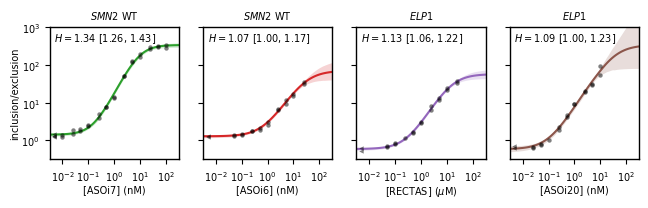

In [14]:
# Fig6A-D
fig, axs = plt.subplots(1,4,figsize=[6.5, 2.1])
axs = axs.ravel()

# Define panel contents
minigenes = ['$SMN2$ WT', '$SMN2$ WT', '$ELP1$', '$ELP1$']
drugs = ['ASOi7', 'ASOi6', 'RECTAS', 'ASOi20']
sheet_names = ['t25a_asoi7_v2', 't25a_asoi6', 'elp1_rectas', 'elp1_aso']
colors = ['C2','C3','C4','C5']
units = ['nM', 'nM', '$\mu$M', 'nM']

# Plot panels
for i in range(4):
    plot_single_drug(ax=axs[i],
                 minigene=minigenes[i],
                 drug=drugs[i],
                 sheet_name=sheet_names[i],
                 color=colors[i],
                 units=units[i],
                 show_ylabel=(i==0),
                 show_yticklabels=(i==0),
                 xlim=[10**-2.5, 10**2.5],
                 ylim = [10**-0.5, 10**3.0],
                 text_fontsize=7)

# Save figure
fig_file = f'fig6A-D.pdf'
fig.tight_layout(w_pad=2)
fig.savefig(fig_file, facecolor='white')
print(f'Plot saved to {fig_file}')

Plot saved to fig6E-K.pdf


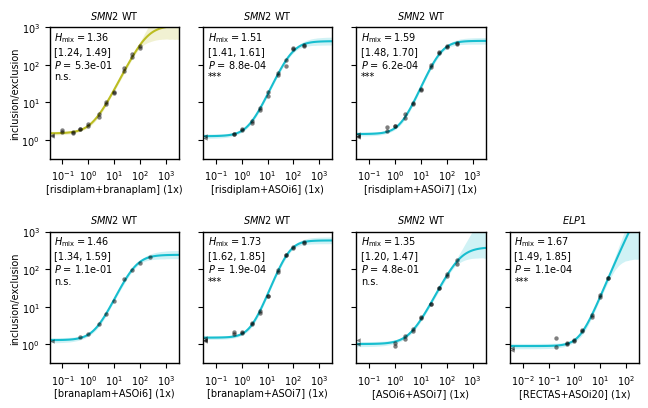

In [15]:
# Create figure
fig, axs = plt.subplots(2,4,figsize=[6.5,4.1])

smn2_kwargs = dict(minigene='$SMN2$ WT',
                   xlim=[10**-1.5, 10**3.5],
                   ylim = [10**-0.5, 10**3.0])

plot_mix(ax=axs[0,0],
         mix_name='risdiplam/branaplam',
         drug1_sheet='t25a_ris_v2',
         drug2_sheet='t25a_bran_v5',
         mix_sheet='t25a_ris_bran_v2',
         color='C8',
         show_ylabel=True,
         **smn2_kwargs)

plot_mix(ax=axs[0,1],
         mix_name='risdiplam/ASOi6',
         drug1_sheet='t25a_ris_v2',
         drug2_sheet='t25a_asoi6',
         mix_sheet='t25a_ris_asoi6_v4',
         color='C9',
         show_ylabel=False,
         **smn2_kwargs)

plot_mix(ax=axs[0,2],
         mix_name='risdiplam/ASOi7',
         drug1_sheet='t25a_ris_v2',
         drug2_sheet='t25a_asoi7_v2',
         mix_sheet='t25a_ris_asoi7_v2',
         color='C9',
         show_ylabel=False,
         **smn2_kwargs)

axs[0,3].axis('off')

plot_mix(ax=axs[1,0],
         mix_name='branaplam/ASOi6',
         drug1_sheet='t25a_bran_v5',
         drug2_sheet='t25a_asoi6',
         mix_sheet='t25a_bran_asoi6_v2',
         color='C9',
         show_ylabel=True,
         **smn2_kwargs)

plot_mix(ax=axs[1,1],
         mix_name='branaplam/ASOi7',
         drug1_sheet='t25a_bran_v5',
         drug2_sheet='t25a_asoi7_v2',
         mix_sheet='t25a_bran_asoi7',
         color='C9',
         show_ylabel=False,
         **smn2_kwargs)

plot_mix(ax=axs[1,2],
         mix_name='ASOi6/ASOi7',
         drug1_sheet='t25a_asoi6',
         drug2_sheet='t25a_asoi7_v2',
         mix_sheet='t25a_asoi6_asoi7_v3',
         color='C9',
         show_ylabel=False,
         **smn2_kwargs)

plot_mix(ax=axs[1,3],
         mix_name='RECTAS/ASOi20',
         drug1_sheet='elp1_rectas',
         drug2_sheet='elp1_aso',
         mix_sheet='elp1_rectas_aso',
         color='C9',
         show_ylabel=False,
         minigene='$ELP1$',
         xlim=[10**-2.5, 10**2.5],
         ylim=[10**-0.5, 10**3.0])

#axs[].axis('off')
               
# Save figure
fig_file = f'fig6E-K.pdf'
fig.tight_layout(w_pad=2, h_pad=2)
fig.savefig(fig_file, facecolor='white')
print(f'Plot saved to {fig_file}')

In [16]:
def ramp_model(x, y=None):
    a = numpyro.sample("a", dist.Normal(loc=0, scale=10))
    b = numpyro.sample("b", dist.Normal(loc=0, scale=10))
    c = numpyro.sample("c", dist.Normal(loc=0, scale=10))
    log10_sigma = numpyro.sample("log10_sigma", dist.Uniform(low=-3, high=-1))
    sigma = numpyro.deterministic('sigma', 10.0**log10_sigma)
    yhat = numpyro.deterministic('yhat', a + b*(x-.5) + c*(x-.5)**2)
    numpyro.sample('y', dist.Normal(yhat, sigma), obs=y) 

In [23]:
def draw_linear_mixture(ax,
                        sheet_name,
                        color):

    file_name = '../data/qPCR/linear_mixture_curves.xlsx'
    ylim = [5,200]

    drug_names_dict = {
        'R':'risdiplam',
        'B':'branaplam',
        'Ai6':'ASO i6',
        'Ai7':'ASO i7'
    }
    
    ticks_dict = {
        'R':[0, 2, 4, 6, 8, 10],
        'B':[0, 2, 4, 6, 8, 10],
        'Ai6':[0, 10, 20, 30, 40, 50],
        'Ai7':[0, 5, 10, 15, 20, 25]
    }

    df = pd.read_excel(file_name,
                       sheet_name=sheet_name)
    drug1, drug2 = sheet_name.split('_')
    x = df[drug1].values.reshape(-1,1)
    xticks=ticks_dict[drug1]
    xlim = [xticks[0], xticks[-1]]
    y = 2.**df['deltaCt'].values
    
    # Load MCMC samples
    mcmc_samples = load_mcmc_samples(sheet_name)

    # Define concentration grid
    x_grid = np.linspace(xlim[0],xlim[1],100)
    
    # Compute model predictions on grid
    ppc = Predictive(ramp_model, mcmc_samples)
    ppc_val = ppc(rng_key_predict, x=x_grid/xlim[1])
    y_hat_grid = 2.**np.median(ppc_val['yhat'], axis=0)
    y_lo_grid, y_hi_grid = 2.**hpdi(ppc_val['yhat'], prob=0.95)

    # Plot median model prediction
    ax.semilogy(x_grid, y_hat_grid, '-', color=color)
    
    # Plot predictive interval
    ax.fill_between(x_grid, 
                    y_lo_grid, 
                    y_hi_grid, 
                    alpha=0.2, 
                    interpolate=True,
                    linewidth=0,
                    color=color)

    # Plot datapoints
    ax.scatter(x, y, 
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)
    
    # Set xlim and ylim
    xmin = min(x)
    xmax = max(x)
    xspan = xmax-xmin
    ylim = [5,200]
    ax.set_xlim([xmin-.1*xspan, xmax+.1*xspan])
    ax.set_ylim(ylim)
    
    # Style x-axis
    ax.set_xticks(xticks)
    ax.set_xlabel(f'[{drug_names_dict[drug1]}], [{drug_names_dict[drug2]}]', labelpad=2)
    tick_labels = [f'{t1}x, {t2}x' for t1,t2 in zip(ticks_dict[drug1],ticks_dict[drug2][::-1])]
    ax.tick_params(axis='x', which='major', pad=0)
    ax.set_xticklabels(tick_labels, rotation=45)    

    # Compute significance of effective H
    ys_grid = ppc_val['yhat']
    num_samples = ys_grid.shape[0]
    no_synergy = ((np.max(ys_grid, axis=1) <= np.max(ys_grid[:,[0,-1]], axis=1))) #& \
                          #((np.min(ys_grid, axis=1) >= np.min(ys_grid[:,[0,-1]], axis=1)))
    pval = np.sum(no_synergy)/num_samples
    
    # Show pvalue
    if pval > 0:
        pval_text = f'$P$ = {pval:.1e}'
    else:
        pval_text = f'$P$ < {1/num_samples:.1e}'
    if pval < .001:
        pval_summary='***'
    elif pval < .01:
        pval_summary='**'
    elif pval < .05:
        pval_summary='*'
    else:
        pval_summary='n.s.'
    ax.text(s=f'{pval_text}\n{pval_summary}', 
            x=0, 
            y=ylim[1]/1.2, 
            ha='left', va='top', fontsize=7)

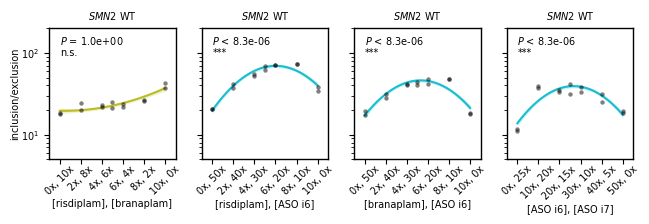

In [26]:
fig, axs = plt.subplots(1,4,figsize=[6.5,2.25], sharey=True)

draw_linear_mixture(axs[0], 'R_B', color='C8')
axs[0].set_ylabel('inclusion/exclusion')
axs[0].set_title('$SMN2$ WT')

draw_linear_mixture(axs[1], 'R_Ai6', color='C9')
axs[1].set_title('$SMN2$ WT')

draw_linear_mixture(axs[2], 'B_Ai6', color='C9')
axs[2].set_title('$SMN2$ WT')

draw_linear_mixture(axs[3], 'Ai6_Ai7', color='C9')
axs[3].set_title('$SMN2$ WT')

fig.tight_layout()
fig.tight_layout(w_pad=1.5, h_pad=2)
fig.savefig('fig6L-O.pdf', facecolor='white')